In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.style.use('ggplot')

import tensorflow as tf
from tensorflow.keras.utils import plot_model

!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback

MODEL_DIR = '/content/drive/MyDrive/saved_models/EmotionRecognition_EfficientNetB4_model/'


## Основное задание

**Описание задачи (легенда)**

Привет! Мы — компания самыезрелищныесериалы.рф, и в нашем сервисе много сериалов. Чтобы завоевать интерес зрителей, мы показываем им трейлеры — небольшие видеоролики, состоящие из наиболее зрелищных моментов сериалов.

Мы долго думали, как находить зрелищные моменты, и решили привлечь для помощи зрителей. Для этого перед презентацией сериала широкой аудитории мы просим разных людей посмотреть этот сериал и снимаем их эмоции на камеру. Так мы видим моменты, в которые зритель был наиболее впечатлён, и используем их при монтаже ролика.

Число сериалов, готовых к запуску, стремительно растёт, нам всё сложнее отсматривать эмоции зрителей в ручном режиме. Мы решили приспособить для этого нейронную сеть, поэтому обратились за помощью к вам. Ваши предсказания мы используем для автоматического составления трейлеров, а также для анализа фильмов и сериалов, чтобы в дальнейшем получить идеальный с точки зрения эмоций зрителя контент.

А если вы сильны не только в обучении моделей компьютерного зрения, то у нас дополнительная просьба. Создайте для наших асессоров скрипт, который будет работать с их веб-камерами и выводить на экран текущую эмоцию.

**Технические требования**

Время инференса сети на Google Colab не должно превышать 0,33 секунды (3 кадра в секунду).

Необходимо, чтобы результат на private leaderboard был > 0,4

### Загрузка изображений с эмоциями

In [ ]:
!gdown --id 1QdhIxh1QUEuLgRb7DWa7RA7CA08ybNRJ
!unzip '/content/train.zip'

!gdown --id 1bGHeWeWYXj5biL9s-qTc9gyv91WNAbWE
!unzip '/content/test_kaggle.zip'

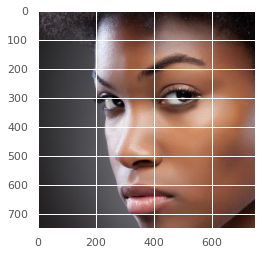

In [ ]:
# Посмотрим пример загруженного изображения
img = plt.imread('/content/train/anger/1.jpg')
plt.imshow(img);

In [ ]:
BATCH_SIZE = 64
IMG_SHAPE = 150

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
      # rescale=1./255,
      rotation_range=40,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=True, # случайное отражение по горизонтали
      fill_mode="nearest", # чем заполнять пробелы
      validation_split=0.2,
      # preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

train_image_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='sparse',
    subset='training',
    seed=42,
    )

valid_image_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='sparse',
    subset='validation',
    seed=42,
    )

# Сразу создаю словарь, по которому буду декодировать результат
class_indices = {k:v for k,v in enumerate(train_image_data_gen.class_indices.keys())}
class_indices

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}

### Выбор и загрузка модели
За основу возьму модель на imagenet с хорошим балансом точности и производительности - EfficientNetB4

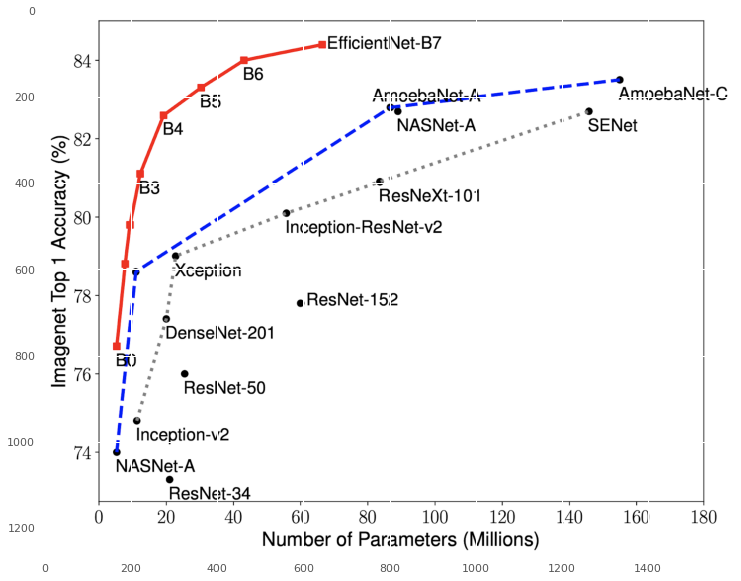

In [ ]:

matplotlib.rc('figure', figsize=(15, 10))
matplotlib.rc('font', size=18)
img = plt.imread('https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png')
plt.imshow(img);

In [ ]:
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet',)

base_model.trainable = False


### Transfer-Learning
Для данной техники требуется вместо выходных слоев базовой модели, предобученной на Imagenet, добавить и обучить свои.



In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(9, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 5, 5, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_15  (None, 1792)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               918016    
_________________________________________________________________
dense_58 (Dense)             (None, 9)                 4617      
Total params: 18,596,456
Trainable params: 922,633
Non-trainable params: 17,673,823
_________________________________________________________________


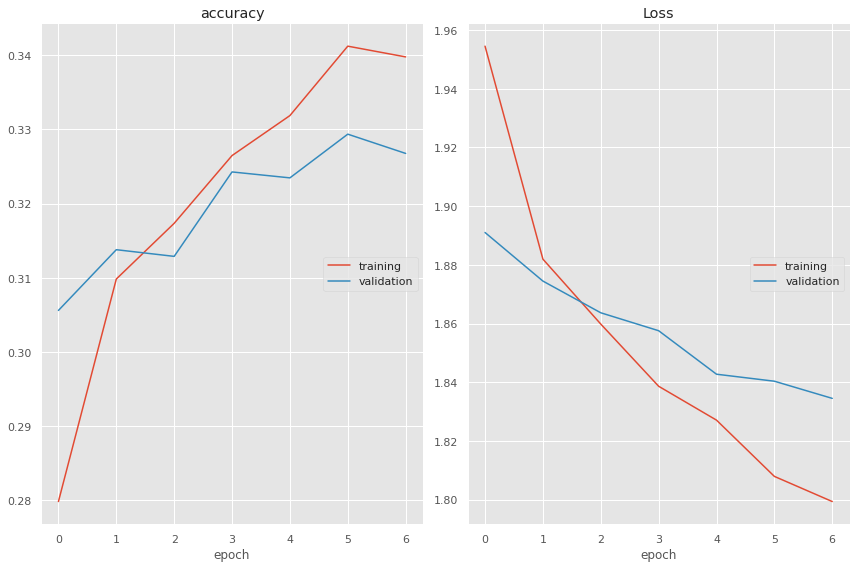

accuracy
	training         	 (min:    0.280, max:    0.341, cur:    0.340)
	validation       	 (min:    0.306, max:    0.329, cur:    0.327)
Loss
	training         	 (min:    1.799, max:    1.955, cur:    1.799)
	validation       	 (min:    1.834, max:    1.891, cur:    1.834)


In [ ]:
EPOCHS = 7

history = model.fit(
    train_image_data_gen,
    epochs=EPOCHS,
    validation_data=valid_image_data_gen,
    callbacks=[PlotLossesCallback()]
    )


Модель обучилась до accuracy: 0.327
<br> По кривым обучения видно, что если продолжить то модель будет переобучать. Приостанавливаю обучение, сохраняю результат.

In [ ]:
model.save(MODEL_DIR + '1')


### Fine-tuning
Для данной техники требуется разблокировать обучение для части либо всех слоев, включая базовую модель, и дообучиться на пониженным learning_rate.

In [ ]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 5, 5, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_15  (None, 1792)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               918016    
_________________________________________________________________
dense_58 (Dense)             (None, 9)                 4617      
Total params: 18,596,456
Trainable params: 18,471,249
Non-trainable params: 125,207
_________________________________________________________________


In [ ]:
EPOCHS = 2
# Выполнено несколько итеграций обучения. Реальное количество эпох: 10

history = model.fit(
    train_image_data_gen,
    epochs=EPOCHS,
    validation_data=valid_image_data_gen,
    callbacks=[PlotLossesCallback()]
    )


Epoch 1/2
626/626 [==============================] - 677s 1s/step - loss: 1.5646 - accuracy: 0.4303 - val_loss: 1.5718 - val_accuracy: 0.4270
Epoch 2/2
626/626 [==============================] - 676s 1s/step - loss: 1.5278 - accuracy: 0.4436 - val_loss: 1.5524 - val_accuracy: 0.4349


С помощью Fine-Tuning удалось значительно поднять результат. Новый score: 0.4349

Дальше переобучение - останавливаюсь, сохраняю результат.

In [ ]:
model.save(MODEL_DIR + '3')


### Predict
Теперь необходимо сделать предикт на тестовых данных и проверить скорость работы модели.

In [ ]:
# Подгружаю в генератор тестовый датасэт из задания
test_image_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_image_data_gen = test_image_gen.flow_from_directory(
    directory='/content',
    classes=['test_kaggle'],
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    seed=42
    )

Found 5000 images belonging to 1 classes.


In [ ]:
# model = tf.keras.models.load_model(MODEL_DIR + '3')


In [ ]:
# Предикт всей выборки
%time preds = model.predict(test_image_data_gen)

CPU times: user 37.6 s, sys: 461 ms, total: 38.1 s
Wall time: 34.9 s


- 34 секунды на 5000 предиктов либо 7 милисекунд на 1 предикт.
- По условиям задачи время на один предикт не должно превышать 330мс
- При этом предикт выполнялся с генератора. Если подавать на вход готовый тензор либо np.array, то скорость еще увеличиться.
- Также для ускорения можно использовать оптимизацию TensorRT.

In [ ]:
# собираю датафрейм из предсказаний, сохраняю csv
df = pd.DataFrame({'image_path':test_image_data_gen.filenames, 'emotion':np.argmax(preds, axis=1)})
df['image_path'] = df.image_path.str[12:]
df['emotion'] = df.emotion.apply(lambda x: class_indices[x])
df.to_csv('/content/submition10.csv', index=False)
df

,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,10.jpg,neutral
3,100.jpg,uncertain
4,1000.jpg,happy
...,...,...
4995,995.jpg,happy
4996,996.jpg,happy
4997,997.jpg,anger
4998,998.jpg,neutral


##### Результат
По условиям задачи для оценки «5» необходимо, чтобы результат на private leaderboard был > 0,4, а также нужно выполнить все пункты из раздела «Для повышения оценки».
- Private Score: 0.42280
- Public Score: 0.44440


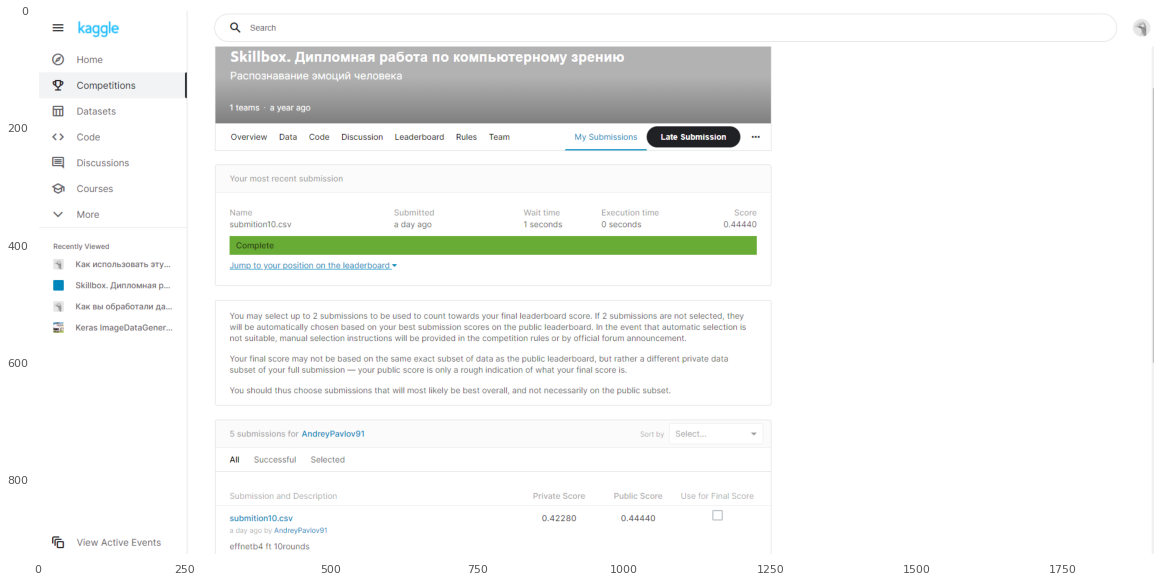

In [ ]:
!gdown --id 1nj2T5ZW2oYbDzefgAZ_QM1SuAkfExtU2

img = plt.imread('/content/diploma_submission.png')
plt.figure(figsize=(20,20))
plt.grid(False)
plt.imshow(img);

## Дополнительное задание Valence-Arousal

#### Получить векторное представление эмоций
В виду отсутствия таблицы соотстветствия задаю для каждой эмоции рейтинги valence и arousal самостоятельно.

In [ ]:
# Знак
valence_scores = {
  'anger': -0.9,
  'contempt': -0.5,
  'disgust': -0.9,
  'fear': -0.5,
  'happy': 0.9,
  'neutral': 0,
  'sad': -1,
  'surprise': 0.3,
  'uncertain': -0.1
}

# Интенсивность
arousal_scores = {
  'anger': 0.9,
  'contempt': -0.5,
  'disgust': 0,
  'fear': 0.9,
  'happy':  0.9,
  'neutral': -0.9,
  'sad': 0.3,
  'surprise': 0.8,
  'uncertain': -0.6
 }
 

#### Feature extraction
Для данной техники необходимо от базовой модели получить выходы с одного из последних слоев и обучить на них новые слои, которые затем добавить вместо выходного слоя базовой модели. Таким образом получим новую модель с той же базой, но другими предобученными выходами.

In [ ]:
#@title Вспомогательные функции obtain_VA_classes и show_faces

def obtain_VA_classes(data_gen):
  'Возвращает valence и aurosal таргеты из генератора изображений'
  
  df = pd.DataFrame({'filepath':data_gen.filepaths, 'class_indices':data_gen.classes})
  df['emotion'] = df.class_indices.apply(lambda x: class_indices[x])
  df['valence_score'] = df.emotion.apply(lambda x: valence_scores[x])
  df['arousal_score'] = df.emotion.apply(lambda x: arousal_scores[x])

  return df.valence_score.values, df.arousal_score.values


def show_faces(model=VA_model,
               emotion_model=None,
               img_gen=test_image_data_gen):

  img_gen.shuffle = False
  data = next(img_gen)
  VA_pred = model.predict(data)
  if emotion_model is not None:
    emotions = emotion_model.predict(data)

  plt.figure(figsize=(12,12))

  for i in range(16):
    plt.subplot(4,4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i]/255)
    if emotion_model is None:
      plt.title(f'valence = {VA_pred[0][i][0]:.2f}\narousal = {VA_pred[1][i][0]:.2f}')
    else:
      plt.title(f'emotion = {class_indices[np.argmax(emotions[i])]}\nval = {VA_pred[0][i][0]:.2f}, ar = {VA_pred[1][i][0]:.2f}')

  plt.subplots_adjust(wspace=0.4)


In [ ]:
# старые метки классов больше не нужны - тип эмоции
train_image_data_gen.class_mode=None
valid_image_data_gen.class_mode=None

# x и y будут из разных объектов. чтобы не перепутать отключаю перемешивание
train_image_data_gen.shuffle = False
valid_image_data_gen.shuffle = False

# получаю новые метки знака (valence) и интенсивности (arousal)
valence_train_score, arousal_train_score = obtain_VA_classes(train_image_data_gen)
valence_valid_score, arousal_valid_score = obtain_VA_classes(valid_image_data_gen)


In [ ]:
# подгружаю базовую модель, на который получу инпуты для feature extraction
VA_base_model = tf.keras.models.load_model(MODEL_DIR + '3')
VA_base_model = tf.keras.Model([VA_base_model.input], VA_base_model.get_layer("dense_57").output)
VA_base_model.trainable = False
VA_base_model.summary()

In [ ]:
#получаю выходы основной модели с предпоследнего слоя (dense_57)
valence_train_input = VA_base_model.predict(train_image_data_gen)
valence_valid_input = VA_base_model.predict(valid_image_data_gen)
arousal_train_input = VA_base_model.predict(train_image_data_gen)
arousal_valid_input = VA_base_model.predict(valid_image_data_gen)


In [ ]:
# Инициализирую новые сетки для знака и интенсивности. Дальше скопирую с них веса и получу новую сетку
valence_model = tf.keras.Sequential([tf.keras.layers.Input(shape=512),
                     tf.keras.layers.Dense(128, 'relu'),
                     tf.keras.layers.Dense(1,)
                     ])

valence_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                     loss='mean_squared_error',
                     metrics=['mean_squared_error'])

arousal_model = tf.keras.Sequential([tf.keras.layers.Input(shape=512),
                     tf.keras.layers.Dense(128, 'relu'),
                     tf.keras.layers.Dense(1,)
                     ])

arousal_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
                     loss='mean_squared_error',
                     metrics=['mean_squared_error'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


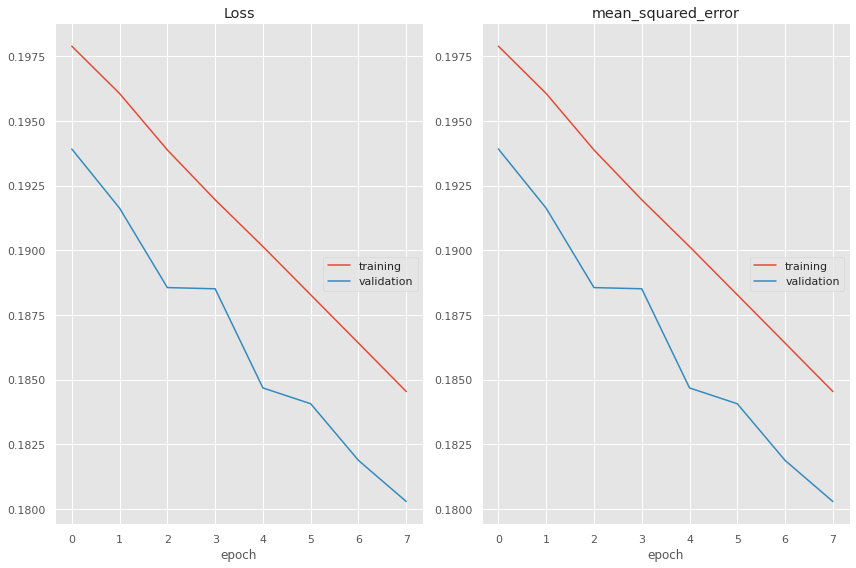

Loss
	training         	 (min:    0.185, max:    0.198, cur:    0.185)
	validation       	 (min:    0.180, max:    0.194, cur:    0.180)
mean_squared_error
	training         	 (min:    0.185, max:    0.198, cur:    0.185)
	validation       	 (min:    0.180, max:    0.194, cur:    0.180)
INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/EmotionRecognition_EfficientNetB4_model/valence/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/EmotionRecognition_EfficientNetB4_model/valence/1/assets


In [ ]:
EPOCHS = 24

history_valence = valence_model.fit(
    x=valence_train_input,
    y=valence_train_score,
    epochs=EPOCHS,
    validation_data=(valence_train_input, valence_train_score),
    callbacks=[PlotLossesCallback()]
    )
valence_model.save(MODEL_DIR + 'valence/1')


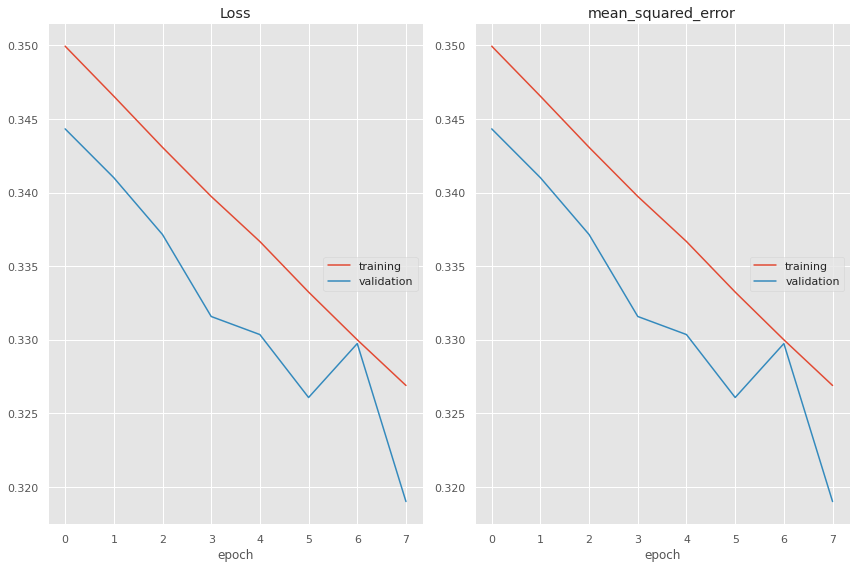

Loss
	training         	 (min:    0.327, max:    0.350, cur:    0.327)
	validation       	 (min:    0.319, max:    0.344, cur:    0.319)
mean_squared_error
	training         	 (min:    0.327, max:    0.350, cur:    0.327)
	validation       	 (min:    0.319, max:    0.344, cur:    0.319)
INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/EmotionRecognition_EfficientNetB4_model/arousal/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/EmotionRecognition_EfficientNetB4_model/arousal/1/assets


In [ ]:
history_arousal = arousal_model.fit(
    x=arousal_train_input,
    y=arousal_train_score,
    epochs=EPOCHS,
    validation_data=(arousal_train_input, arousal_train_score),
    callbacks=[PlotLossesCallback()]
    )

arousal_model.save(MODEL_DIR + 'arousal/1')


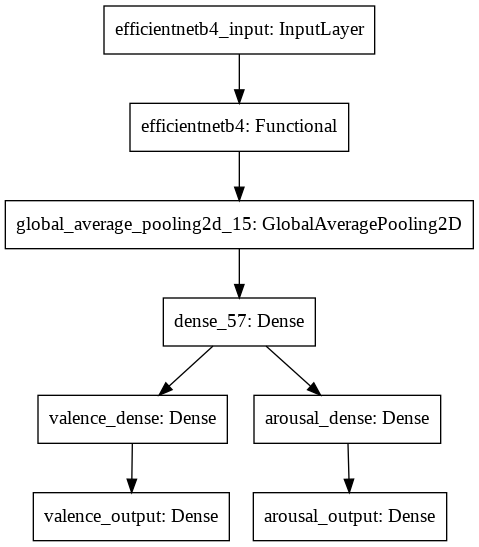

In [ ]:
# Модели, с которых буду забирать веса, обучены. Теперь собраю новую сеть VA_model.

valence_dense = tf.keras.layers.Dense(128, 'relu', name='valence_dense')(VA_base_model.output)
valence_output = tf.keras.layers.Dense(1, name='valence_output')(valence_dense)

arousal_dense = tf.keras.layers.Dense(128, 'relu', name='arousal_dense')(VA_base_model.output)
arousal_output = tf.keras.layers.Dense(1, name='arousal_output')(arousal_dense)

VA_model = tf.keras.Model(inputs=[VA_base_model.input], outputs=[valence_output, arousal_output])

# # Компиляция не обязательна, ведь дообучать модель нет необходимости
# VA_model.compile(optimizer='Adam', 
#               loss='mean_squared_error',
#               metrics=['mean_squared_error'])

plot_model(VA_model)

In [ ]:
# Копирую веса в новую модель

VA_model.get_layer('valence_dense').set_weights(valence_model.get_layer('dense').get_weights())
VA_model.get_layer('valence_output').set_weights(valence_model.get_layer('dense_1').get_weights())

VA_model.get_layer('arousal_dense').set_weights(arousal_model.get_layer('dense_2').get_weights())
VA_model.get_layer('arousal_output').set_weights(arousal_model.get_layer('dense_3').get_weights())


In [ ]:
VA_model.save(MODEL_DIR + 'VA_model/1')
# VA_model = tf.keras.models.load_model(MODEL_DIR + 'VA_model/1')

#### Predict

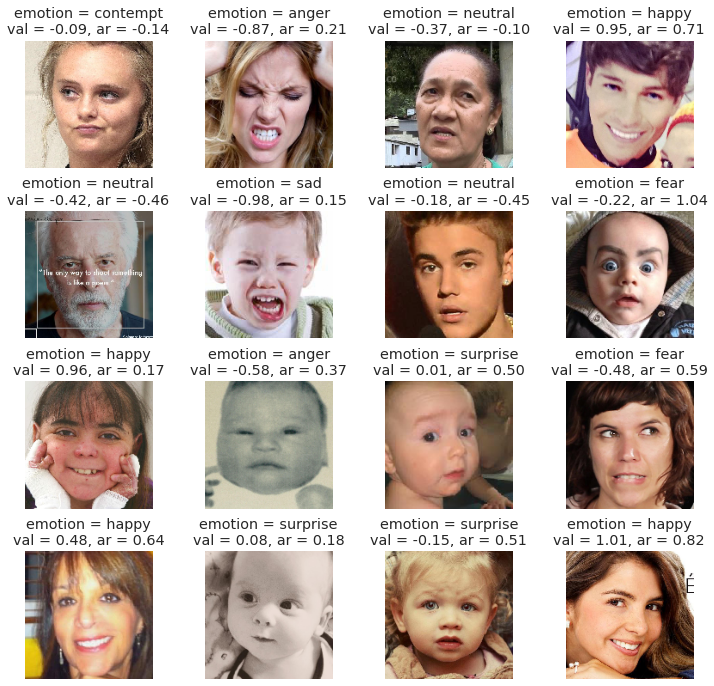

In [ ]:
# Выполняю предик и сразу вывожу несколько примеров

show_faces(model=VA_model, emotion_model=model, img_gen=test_image_data_gen)

## Выводы
Люди способны выражать широкий спектр эмоций. Каждый человек выражает эмоции несколько по-разному. И тем не менее робот уже способен с высокой точностью определять, притом делать это в различных формах - как выбор из дискретного набора, так и значение на непрерывных спектрах в случае знака и интенсивности.

Данная технология может помогать отслеживать user experience от просмотра сериала или вождения автомобиля, комфорт работы в больших компаниях и даже состояние пациентов в больницах, предоставляя возможность реагировать еще до получения сигналов жизненных показателях.